# Imports

In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Data

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/Text_Mining_Project_Amazon/")
!pwd

/content/drive/MyDrive/Text_Mining_Project_Amazon


In [ ]:
reviews = pd.read_csv("AmazonFinal_classification.csv")

In [ ]:
df = reviews

In [ ]:
df.head()

,Text,Summary,Score,Time,HelpfulnessNumerator
0,I bought several Vitality canned dog food prod...,Good Quality Dog Food,5,1303862400,1
1,Product arrived labeled Jumbo Salted Peanutsth...,Not as Advertised,1,1346976000,0
2,This confection around centuries It light pill...,"""Delight"" says it all",4,1219017600,1
3,If looking secret ingredient Robitussin I beli...,Cough Medicine,2,1307923200,3
4,Great taffy great price There wide assortment ...,Great taffy,5,1350777600,0


we now prepare the data for the binary classification task, splitting as explained into the report between Positive and Negative.

In [ ]:
conditions = [
    (df['Score'] <= 3),
    (df['Score'] >= 4)
    ]
values = [ 'Negative' , 'Positive']
df['Polarity'] = np.select(conditions, values)

We have two classes in the dataset

In [ ]:
df.Polarity.unique()

array(['Positive', 'Negative'], dtype=object)

Let's check how equally distributed those classes are.

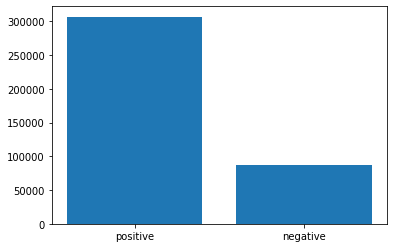

In [ ]:
classes = df.Polarity.unique()
counts = []

for i in classes:
  count = len(df[df.Polarity==i])
  counts.append(count)

plt.bar(['positive', 'negative'], counts)
plt.show()

In [ ]:
for i in classes:
  count = len(df[df.Polarity==i])
  print(count)

306887
86848


In [ ]:
#df.loc[df['Polarity'] == 'positive']

positive = df.loc[df['Polarity'] == 'Positive']
negative = df.loc[df['Polarity'] == 'Negative']

In [ ]:
positive = positive.sample(n = 86848)

In [ ]:
frames = [positive, negative]

result = pd.concat(frames)

In [ ]:
df = result
df.columns

Index(['Text', 'Summary', 'Score', 'Time', 'HelpfulnessNumerator', 'Polarity'], dtype='object')

In [ ]:
df

,Text,Summary,Score,Time,HelpfulnessNumerator,Polarity
212099,Twinings seem discontinued applecinnamon flavo...,very tasty,4,1332028800,0,Positive
114583,A true reward faithful companion loves Heshe a...,Woof Woof treats,5,1257984000,0,Positive
292104,I purchased product calories serving When arri...,Great for dieting.,4,1318636800,0,Positive
387976,Very yummy I one burned piece bag things incre...,Yummy!,4,1231545600,0,Positive
238470,Twinings Tea favorite I drinking approx years ...,Yum!,5,1340928000,0,Positive
...,...,...,...,...,...,...
393714,I bought soup today local grocer brought back ...,Tastes horrible!,1,1311638400,0,Negative
393715,This soup mostly broth Although kick also swee...,Not so good,2,1306368000,0,Negative
393716,It mostly broth advertised cup vegetables Howe...,Where's the tortellini?,2,1285718400,0,Negative
393727,I ordered months back great latest batch terri...,Mixed wrong,2,1328918400,0,Negative


## Train/test split

We can take a sample of 10% or 5% (to avoid GPU overload) and then split that into 80% for training and 20% for testing.

In [ ]:
sample_size = int(len(df)*0.05)   
sampleDf = df.sample(sample_size, random_state=23)
x = sampleDf.Text.values #text
y = sampleDf.Polarity.values  #target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

## Label Encoding

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

We might want to use encoding for later. For that we can save enconding map.

In [ ]:
encoder_fname = 'text_classes.npy'
my_wd = '/content/drive/MyDrive/Text_Mining_Project_Amazon/TextClassificationRepo'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

## Tokenization

To tokenize our text we will use some functions from official.nlp.bert package and the pretrained [BERT](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270) model itself. \\
First we get the BERT model. We use a model that takes capital words into account, in order to intercept references to cities, products, people.... To check all NLP models provided by TF HUB go [here](https://tfhub.dev/s?module-type=text-embedding,text-classification,text-generation,text-language-model,text-question-answering,text-retrieval-question-answering).

In [ ]:
#also distill Bert (https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1) has also been tested, but the big Bert outperformed 

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2", 
                            trainable=True)





1.   ```vocab_file``` reads the vocab file associated to the downloaded model.
2.   ```do_lower_case``` reads binary variable which if ```True``` means tokenizer will reformat all text to lower case rendering model to be **NOT** case sensitive. Should be ```False``` by default. You can check in a cell below.
3.   ```tokenizer``` builds tokenizer using variables 1 and 2.



In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
do_lower_case

False

In [ ]:
vocab_file

b'/tmp/tfhub_modules/3e9209b9f2a53dfa4e6d93250dfceb5e64d73b66/assets/vocab.txt'

Lastly we need to add two additional tokens: Classification and Seperation.
 We will add these through functions we will use to tokenize our text.

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. 
   return tokenizer.convert_tokens_to_ids(tokens)

text_reviews = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized Text shape', text_reviews.shape.as_list())

Tokenized Text shape [6947, None]


In [ ]:
text_reviews[0]

<tf.Tensor: shape=(124,), dtype=int32, numpy=
array([   146,  68351,    187,  10812,  13362,  28780,  45726,  27636,
        15555,  10117,  10422,  10635,    146,  68507,  17761,    146,
        23742,  12474,  24074,  10514,  10627,  25635,  36884,  23005,
        11918,    198,  54434,  12174,  21766,  10454,  15329,  17121,
          146,  28236,  54434,  23005,  11918,  21766,  10454,  48323,
        84298,    146,  15910,  26664,  10525,  23005,  11918,  28757,
        10379,  23742,    159,  53814,    153,  37079,  14927,  23005,
        11918,  10173,  10812,  42068,  11340,  11940,    146,  17044,
        23005,  11918,  20054,  28236,  12286,  55768,  53183,  12015,
        11203,  26742,  62452,  28236,  11206,  45415,  10107,  90424,
        30518,  25249,  10157,  36867,  33989,    146,  38008,  13172,
        17004,  11709,    146,  69423,  10882,  30455,  10198,  85779,
        91347,  67952,  96021,  34208,  15217,  16745,  17684,  10167,
        32282,  11206,  66166, 

If you want to see how tokenizer does the "tokenizing" check the cells below.

In [ ]:
x_train[0]

'I drinking scoop stuff daily months The first time I drank I mixed small amount pomegranate juice ~oz could barely get Now I mix oz juice barely notice taste I usually organge juice morning also mixed V Fusion POM personal juice concoctions One day I ran juice forced mix water favorite tolerable Make sure mix well tends settle grittybr br I feel much healthier I drink As someone suffers chronic fatigue seems help little bit In opinion wellrounded nutritional supplement It fresh energizing excellent deal subscribe save'

In [ ]:
tokenizedText = tokenizer.tokenize(x_train[0])
for i in tokenizedText:
  print(i, tokenizer.convert_tokens_to_ids([i]))

We still need to add classification token.

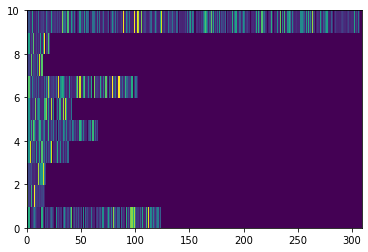

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*text_reviews.shape[0]
input_word_ids = tf.concat([cls, text_reviews], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

What you see above is a graphical representation of our tokenized text. First token is our classification token. Other colored blocks than background are other tokens. And background, well that's just padding.

## Mask and input type

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

In [ ]:
input_word_ids

Output hidden; open in https://colab.research.google.com to view.

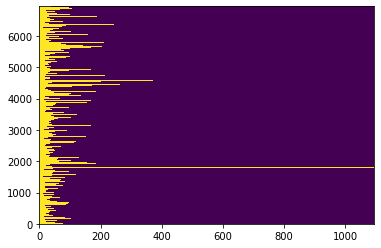

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

Here each yellow block has some input. We just make this for the model to differ between padding and input.

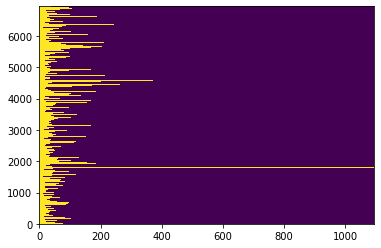

In [ ]:
type_cls = tf.zeros_like(cls)
type_text = tf.ones_like(text_reviews)
input_type_ids = tf.concat([type_cls, type_text], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

It's hard to see but we added an empty block in front of each text for the `[CLS]` token. Check tensor below

In [ ]:
input_type_ids

<tf.Tensor: shape=(6947, 1094), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

## Remake into a function for normal use

So at this point we have all of our three inputs:

1.   Tokens
2.   Input mask
3.   Input type





First let's set the max sequence lenght as we did in simple NN case.

In [ ]:
lens = [len(i) for i in input_word_ids]

In [ ]:
print(lens)

[125, 18, 19, 40, 67, 43, 104, 16, 23, 309, 38, 17, 30, 73, 13, 85, 60, 89, 111, 22, 36, 127, 61, 77, 109, 79, 51, 191, 40, 67, 44, 123, 35, 78, 114, 18, 26, 27, 31, 231, 78, 22, 20, 17, 50, 33, 57, 70, 30, 184, 75, 82, 130, 35, 55, 23, 66, 54, 55, 137, 61, 15, 45, 55, 19, 26, 116, 184, 40, 82, 26, 23, 38, 49, 64, 56, 104, 84, 63, 24, 25, 45, 128, 46, 128, 39, 70, 60, 88, 23, 53, 30, 40, 118, 93, 29, 25, 34, 37, 45, 85, 27, 39, 109, 126, 111, 18, 32, 80, 49, 32, 62, 60, 90, 53, 57, 73, 29, 29, 33, 27, 59, 96, 38, 401, 31, 137, 38, 127, 90, 86, 239, 37, 168, 51, 42, 243, 45, 100, 29, 34, 23, 88, 28, 25, 118, 62, 79, 32, 60, 12, 38, 22, 19, 198, 88, 21, 57, 53, 37, 50, 91, 31, 38, 63, 59, 143, 166, 169, 74, 17, 43, 17, 81, 272, 100, 21, 62, 136, 23, 72, 16, 100, 30, 77, 104, 39, 62, 91, 235, 24, 149, 98, 61, 40, 20, 102, 80, 56, 29, 17, 53, 184, 23, 56, 155, 46, 57, 47, 25, 58, 36, 83, 225, 24, 35, 20, 84, 35, 39, 121, 214, 84, 60, 37, 42, 75, 149, 275, 29, 71, 48, 27, 72, 45, 35, 39, 62

In [ ]:
max(lens)

1094

In [ ]:
np.percentile(lens,99)

333.6199999999999

In [ ]:
max_seq_length = 384 
print('Max length is:', max_seq_length)

Max length is: 384


When using a fraction of data, it is best to increase the number of words that can be entered as much as possible, 512 is the maximum the model allows.

In [ ]:
#max_seq_length = 512  
print('Max length is:', max_seq_length)

Functions themselves.

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

And now we preprocess inputs.

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

# THE MODEL

## Initial training

We need to set up our model using the inputs we made, BERT model that we downloaded and an output layer based on num of classes we are using.

In [ ]:
#version check
!pip list | grep tensorflow

tensorflow                    2.7.0
tensorflow-addons             0.15.0
tensorflow-datasets           4.0.1
tensorflow-estimator          2.7.0
tensorflow-gcs-config         2.7.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.22.0
tensorflow-metadata           1.4.0
tensorflow-model-optimization 0.7.0
tensorflow-probability        0.15.0
tensorflow-text               2.7.3


In [ ]:
num_class = len(encoder.classes_)  
max_seq_length = max_seq_length 

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

Our model.

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

Set up the training parameters.

In [ ]:
epochs = 3
batch_size = 6  # select based on your GPU resources not to go out of memory :(
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Compile the model.

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Set up a history to check our model performance afterwards.

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
1158/1158 [==============================] - 2496s 2s/step - loss: 0.5569 - accuracy: 0.7310 - val_loss: 0.5493 - val_accuracy: 0.7743
Epoch 2/3
1158/1158 [==============================] - 2481s 2s/step - loss: 0.4185 - accuracy: 0.8576 - val_loss: 0.6029 - val_accuracy: 0.8296
Epoch 3/3
1158/1158 [==============================] - 2480s 2s/step - loss: 0.2909 - accuracy: 0.9254 - val_loss: 0.7842 - val_accuracy: 0.8348


Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9633
Testing Accuracy:  0.8348


Noice plots are noice

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

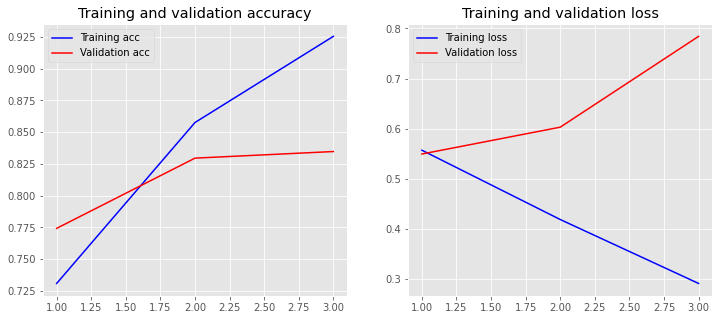

In [ ]:
plot_history(history)

So, looking at the plot above we can see that at the 2nd epoch our `Validation Loss` jumped significantly even though `Validation Accuracy` stayed pretty much the same. 

## Model saving for later use

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'text_BERT'
my_wd = '/content/drive/MyDrive/Text_Mining_Project_Amazon/TextClassificationRepo/Bert_models/'

model.save(os.path.join(my_wd, model_fname))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Text_Mining_Project_Amazon/classification_code_repo/Bert_models/text_BERT/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Text_Mining_Project_Amazon/classification_code_repo/Bert_models/text_BERT/assets


### Validate saved model

In [ ]:
model_fname = 'text_BERT'
my_wd = '/content/drive/MyDrive/Text_Mining_Project_Amazon/TextClassificationRepo/Bert_models/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
new_model.summary()

In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, '/tmp/tfhub_modules/3e9209b9f2a53dfa4e6d93250dfceb5e64d73b66/assets/vocab.txt'), #assets/vocab.txt
    do_lower_case=False)

In [ ]:
tokenizedText = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedText:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

# Test

In [ ]:
encoder_fname = 'text_classes.npy'
my_wd = '/content/drive/My Drive/Text_Mining_Project_Amazon/TextClassificationRepo/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

In [ ]:
encoder.classes_

In [ ]:
text_reviews = ['find Barilla pasta really good Italy is perfect match for fine food perfetto']
inputs = bert_encode(string_list=list(text_reviews), 
                     tokenizer=tokenizerSaved, 
                     max_seq_length=512)

In [ ]:
prediction = new_model.predict(inputs)
print(prediction)
print('Text is', 'positive' if encoder.classes_[np.argmax(prediction)]=='Positive' else 'negative')